<a href="https://colab.research.google.com/github/arnisafazla/CS490/blob/main/CS_490_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/CS490/CS490-Senior-Research-Project

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project


In [ ]:
! git pull

Already up to date.


In [2]:
!git config --global user.email "arnisa.fazla@ug.bilkent.edu.tr"
!git config --global user.name "arnisafazla"
! git add .

fatal: not a git repository (or any of the parent directories): .git


In [5]:
! git commit -m 'try euler angles -> rotation matrix -> 6d representation'

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
	modified:   dataset.py
	modified:   setup.ipynb

Untracked files:
	model.png

no changes added to commit


In [ ]:
! git rm ./models/__pycache__/ -r

fatal: pathspec './models/__pycache__/' did not match any files


In [ ]:
! git check-ignore -v __pycache__/

.gitignore:1:__pycache__	__pycache__/


In [ ]:
! echo 'models/__pycache__' >> .gitignore

In [ ]:
! git add models/
! git add tools.py

In [41]:
! git push origin main

Counting objects: 8, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (8/8), done.
Writing objects: 100% (8/8), 18.20 KiB | 1.52 MiB/s, done.
Total 8 (delta 6), reused 0 (delta 0)
remote: Resolving deltas: 100% (6/6), completed with 6 local objects.
To https://github.com/arnisafazla/CS490-Senior-Research-Project.git
   93bbf64..bd21b85  main -> main


In [3]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model

# path to the cloned repo
main_dir = '/content/drive/MyDrive/CS490/CS490-Senior-Research-Project'  
# path to the dataset folder
dataset_dir = '/content/drive/MyDrive/CS490/dataset'
%cd {main_dir}
sys.path.insert(0,main_dir)
sys.path.insert(0,'/content/drive/MyDrive/CS490')
from dataset import Dataset
from models.critic_models.LSTM_critic import define_critic
from models.critic_models.projection_critic import define_projection_critic
from models.generator_models.norm_generator import define_norm_generator
from models.generator_models.LSTM_generator import define_generator
from models.Base_WGAN import Base_WGAN

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project


In [ ]:
%cd /content/drive/MyDrive/CS490/models
! mkdir models_smoothened_data

/content/drive/MyDrive/CS490/models


In [4]:
# path is the path to the dataset
dataset2 = Dataset(["anger", "joy", "fear", "neutral", "sadness", "pride"], path=dataset_dir, step_size=10, frames=200)
# dataset = Dataset(["anger"], path=dataset_dir, step_size=10, frames=200)

anger


100%|██████████| 65/65 [00:12<00:00,  5.35it/s]


joy


100%|██████████| 29/29 [00:13<00:00,  2.11it/s]


fear


100%|██████████| 32/32 [00:08<00:00,  3.99it/s]


neutral


100%|██████████| 84/84 [00:13<00:00,  6.32it/s]


sadness


100%|██████████| 46/46 [00:08<00:00,  5.43it/s]


pride


100%|██████████| 24/24 [00:04<00:00,  4.88it/s]


In [5]:
Dataset.balance(dataset2)

No. of samples in each class will be:  1114


In [30]:
x.shape

(200, 69)

In [31]:
y = dataset.smoothen(x.reshape(1,200,69))

In [33]:
y*2

array([[[ 0.06679972, -1.58079329, -0.00992502, ...,  1.99994023,
          1.9997152 ,  1.99998914],
        [ 0.06804849, -1.58141419, -0.00958978, ...,  1.99994558,
          1.99971403,  1.99999023],
        [ 0.06915002, -1.5821221 , -0.00926864, ...,  1.99994924,
          1.99971387,  1.99999083],
        ...,
        [ 0.11290094, -1.57528285, -0.02858473, ...,  1.99995003,
          1.99973126,  1.99999067],
        [ 0.11285748, -1.57503477, -0.02856546, ...,  1.99994417,
          1.99972992,  1.99998984],
        [ 0.11301801, -1.57479105, -0.02836522, ...,  1.99994252,
          1.99972824,  1.99998973]]])

In [34]:
z = dataset.atan(y*2)

In [40]:
y.max()

0.9999999998896979

In [36]:
x

array([[ 1.78085973e+02, -5.22225940e+01, -2.84332000e-01, ...,
         4.42967000e-01,  9.66929000e-01,  1.88843000e-01],
       [ 1.78050178e+02, -5.22516400e+01, -2.74728000e-01, ...,
         4.22678000e-01,  9.68918000e-01,  1.79095000e-01],
       [ 1.78018603e+02, -5.22847790e+01, -2.65528000e-01, ...,
         4.08198000e-01,  9.69199000e-01,  1.73493000e-01],
       ...,
       [ 1.76763906e+02, -5.19656420e+01, -8.18920000e-01, ...,
         4.05025000e-01,  9.39278000e-01,  1.74964000e-01],
       [ 1.76765153e+02, -5.19541090e+01, -8.18368000e-01, ...,
         4.28111000e-01,  9.41619000e-01,  1.82592000e-01],
       [ 1.76760547e+02, -5.19427810e+01, -8.12631000e-01, ...,
         4.34394000e-01,  9.44548000e-01,  1.83618000e-01]])

In [5]:
! rm -rf /content/drive/MyDrive/CS490/models/models_smoothened_data/one_class_2022.02.27-15:51:28

In [6]:
# save this as a separate file
config = {       # change hyperparams here
        'latent_dim' : 400,
        'in_shape' : (dataset2.frames, dataset2.n_features),  # because sin and cos values for each value
        'n_classes' : dataset2.emotions.shape[0],
        'init_std' : 0.01,
        'epochs' : 20,
        'batch_size' : 128,
        'n_critic' : 1,
        'dataset_balanced' : True,
        'critic_batch_norm' : False,
        'critic_instance_norm' : False,
        'critic_layer_norm' : False,
        'critic_weight_norm' : False,
        'critic_cond_layer_norm' : False,
        'generator_batch_norm' : False,
        'generator_layer_norm' : False,
        'generator_layer_norm_plus' : True,
        'critic_dropout' : 0.2,
        'gp_weight' : 10.0,      # for the gradient penalty used in critic
        'smoothen' : False
      }

In [17]:
x = dataset.X[0]

In [21]:
x = np.zeros((1, x.shape[0], x.shape[1]))

In [22]:
transformed = dataset.transform(x, smoothen=False)

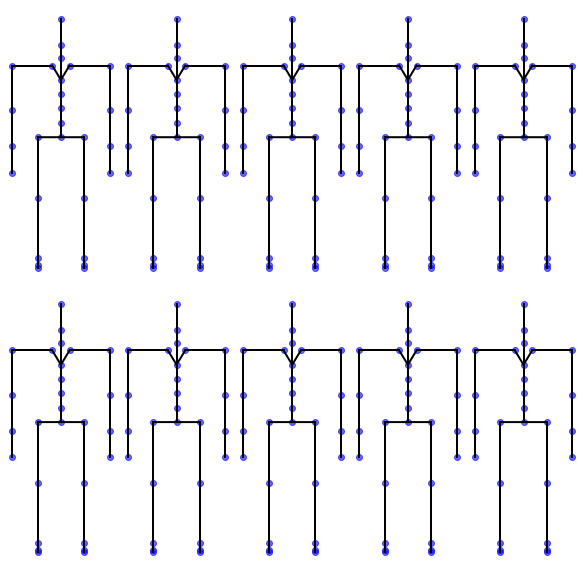

In [24]:
fig = dataset.stickfigure(transformed[0], step=20, cols=5)

In [9]:
! rm -rf /content/drive/MyDrive/CS490/models/one_class_2022.02.28-09:16:54/one_class_2022.02.28-09:16:15

In [7]:
generator = define_norm_generator(config)

In [8]:
critic = define_projection_critic(config)
# plot_model(critic, show_shapes=True, show_layer_names=True)

In [9]:
outputs_path = '/content/drive/MyDrive/CS490/models'
# the saved models, outputs, and config files will go to this folder
gan = Base_WGAN(config, dataset2, outputs_path, 'WGAN_layer_norm_plus_', critic, generator)

In [10]:
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
critic_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
# Define the loss functions for the critic,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def critic_loss(real, fake):
    real_loss = tf.reduce_mean(real)
    fake_loss = tf.reduce_mean(fake)
    return fake_loss - real_loss
# Define the loss functions for the generator.
def generator_loss(fake):
    return -tf.reduce_mean(fake)

# gan = Base_WGAN('/content/drive/MyDrive/CS490/models', 'WGAN', None, critic, generator, config, dataset)

# Compile the WGAN model.
gan.compile(
    c_optimizer=critic_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    c_loss_fn=critic_loss,
)

# Start training the model.
# wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

In [31]:
# load model
model_path = '/content/drive/MyDrive/CS490/models/models_smoothened_data/one_class_2022.02.28-08:59:34/epoch_2'
outputs_path = '/content/drive/MyDrive/CS490/models'
gan = Base_WGAN(config=config, dataset=dataset, dest_dir=outputs_path, name=None, model_load=model_path, critic=None, generator=None)

In [11]:
logs_path = '/content/drive/MyDrive/CS490/logs' # path to the tensorboard logs
gan.train(logs_path)

>1, 1/52, c_loss=9.989, g_loss=0.000
>1, 2/52, c_loss=9.988, g_loss=0.000
>1, 3/52, c_loss=9.986, g_loss=-0.000
>1, 4/52, c_loss=9.985, g_loss=-0.000
>1, 5/52, c_loss=9.983, g_loss=-0.000
>1, 6/52, c_loss=9.981, g_loss=-0.001
>1, 7/52, c_loss=9.978, g_loss=-0.001
>1, 8/52, c_loss=9.975, g_loss=-0.002
>1, 9/52, c_loss=9.972, g_loss=-0.002
>1, 10/52, c_loss=9.968, g_loss=-0.003
>1, 11/52, c_loss=9.965, g_loss=-0.004
>1, 12/52, c_loss=9.958, g_loss=-0.005
>1, 13/52, c_loss=9.951, g_loss=-0.007
>1, 14/52, c_loss=9.944, g_loss=-0.008
>1, 15/52, c_loss=9.935, g_loss=-0.011
>1, 16/52, c_loss=9.921, g_loss=-0.015
>1, 17/52, c_loss=9.907, g_loss=-0.020
>1, 18/52, c_loss=9.892, g_loss=-0.025
>1, 19/52, c_loss=9.869, g_loss=-0.036
>1, 20/52, c_loss=9.847, g_loss=-0.042
>1, 21/52, c_loss=9.821, g_loss=-0.056
>1, 22/52, c_loss=9.764, g_loss=-0.069
>1, 23/52, c_loss=9.736, g_loss=-0.086
>1, 24/52, c_loss=9.640, g_loss=-0.121
>1, 25/52, c_loss=9.592, g_loss=-0.129
>1, 26/52, c_loss=9.434, g_loss=-0.1

KeyboardInterrupt: ignored

In [5]:
[labels_real, X_real], y_real = dataset.generate_real_samples(128, smoothen=False)

In [66]:
! rm -rf /content/drive/MyDrive/CS490/models/models_smoothened_data/WGAN2022.02.26-15:19:21

In [ ]:
for dir in os.listdir('/content/drive/MyDrive/CS490/models/models_smoothened_data'):
  # if dir[0:10] == 'WGAN_layer' and dir != 'WGAN2022.01.26-14:29:43':
  path = os.path.join('/content/drive/MyDrive/CS490/models/models_smoothened_data', dir)
  ! rm -rf $path

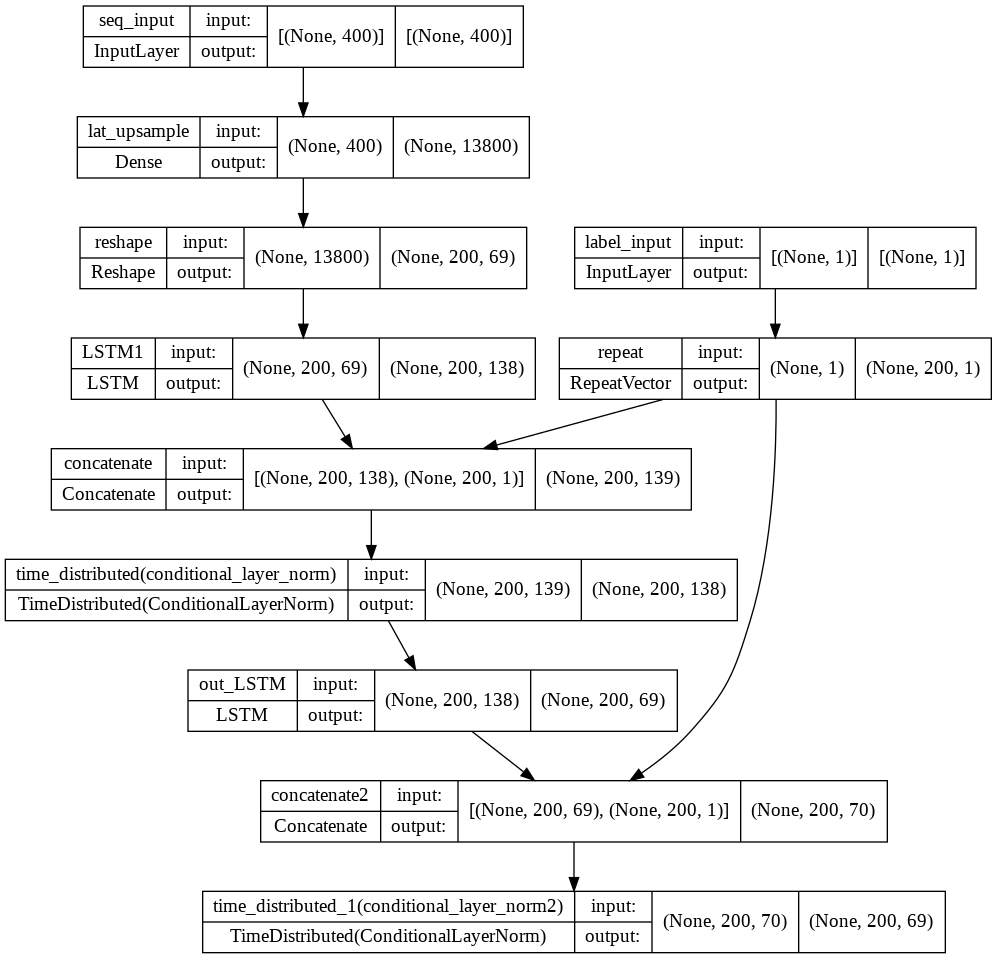

In [8]:
from keras.utils.vis_utils import plot_model
plot_model(generator, show_shapes=True, show_layer_names=True)


In [ ]:
! rm -rf /content/drive/MyDrive/CS490/models/WGAN2022.01.27-14:10:21

In [ ]:
generator = define_generator(config)

In [ ]:
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input (InputLayer)         [(None, 400)]        0           []                               
                                                                                                  
 lat_upsample (Dense)           (None, 27600)        11067600    ['seq_input[0][0]']              
                                                                                                  
 label_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 reshape_2 (Reshape)            (None, 200, 138)     0           ['lat_upsample[0][0]']           
                                                                                          

In [44]:
import json
with open(os.path.join('/content/drive/MyDrive/CS490/models/one_class_2022.02.28-09:48:19/epoch_1', 'train_metrics.txt')) as file:
  tm = json.load(file)

In [ ]:
cm

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [10.0, 10.0, 10.0, 10.0, 10.0, 10.0]]

<function matplotlib.pyplot.figure>

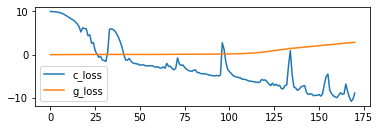

In [24]:
Base_WGAN.plot_history(gan.train_metrics)

In [ ]:
import json
with open(os.path.join('/content/drive/MyDrive/CS490/models/WGAN_layer_norm2022.02.12-20:27:59/epoch_9', 'cm.txt')) as file:
  cm = json.load(file)